# Real Observations

Let's show that this works on pulsar data observed with NuSTAR:

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")
sns.set_palette('colorblind')

import numpy as np
import astropy.io.fits as fits
import scipy.fftpack
import scipy.stats

from stingray import Lightcurve, Powerspectrum, Crossspectrum
from stingray import AveragedPowerspectrum, AveragedCrossspectrum
from stingray.gti import cross_gtis
from stingray import StingrayError

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:20: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


Let's load some data:

In [137]:
1.0/1.24

0.8064516129032259

In [2]:
f1 = fits.open("../data/nu30002006002A01_filt.evt")
toa1 = f1[1].data.field("TIME")

f2 = fits.open("../data/nu30002006002B01_filt.evt")
toa2 = f2[1].data.field("TIME")


/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:73: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


<IPython.core.display.Javascript object>


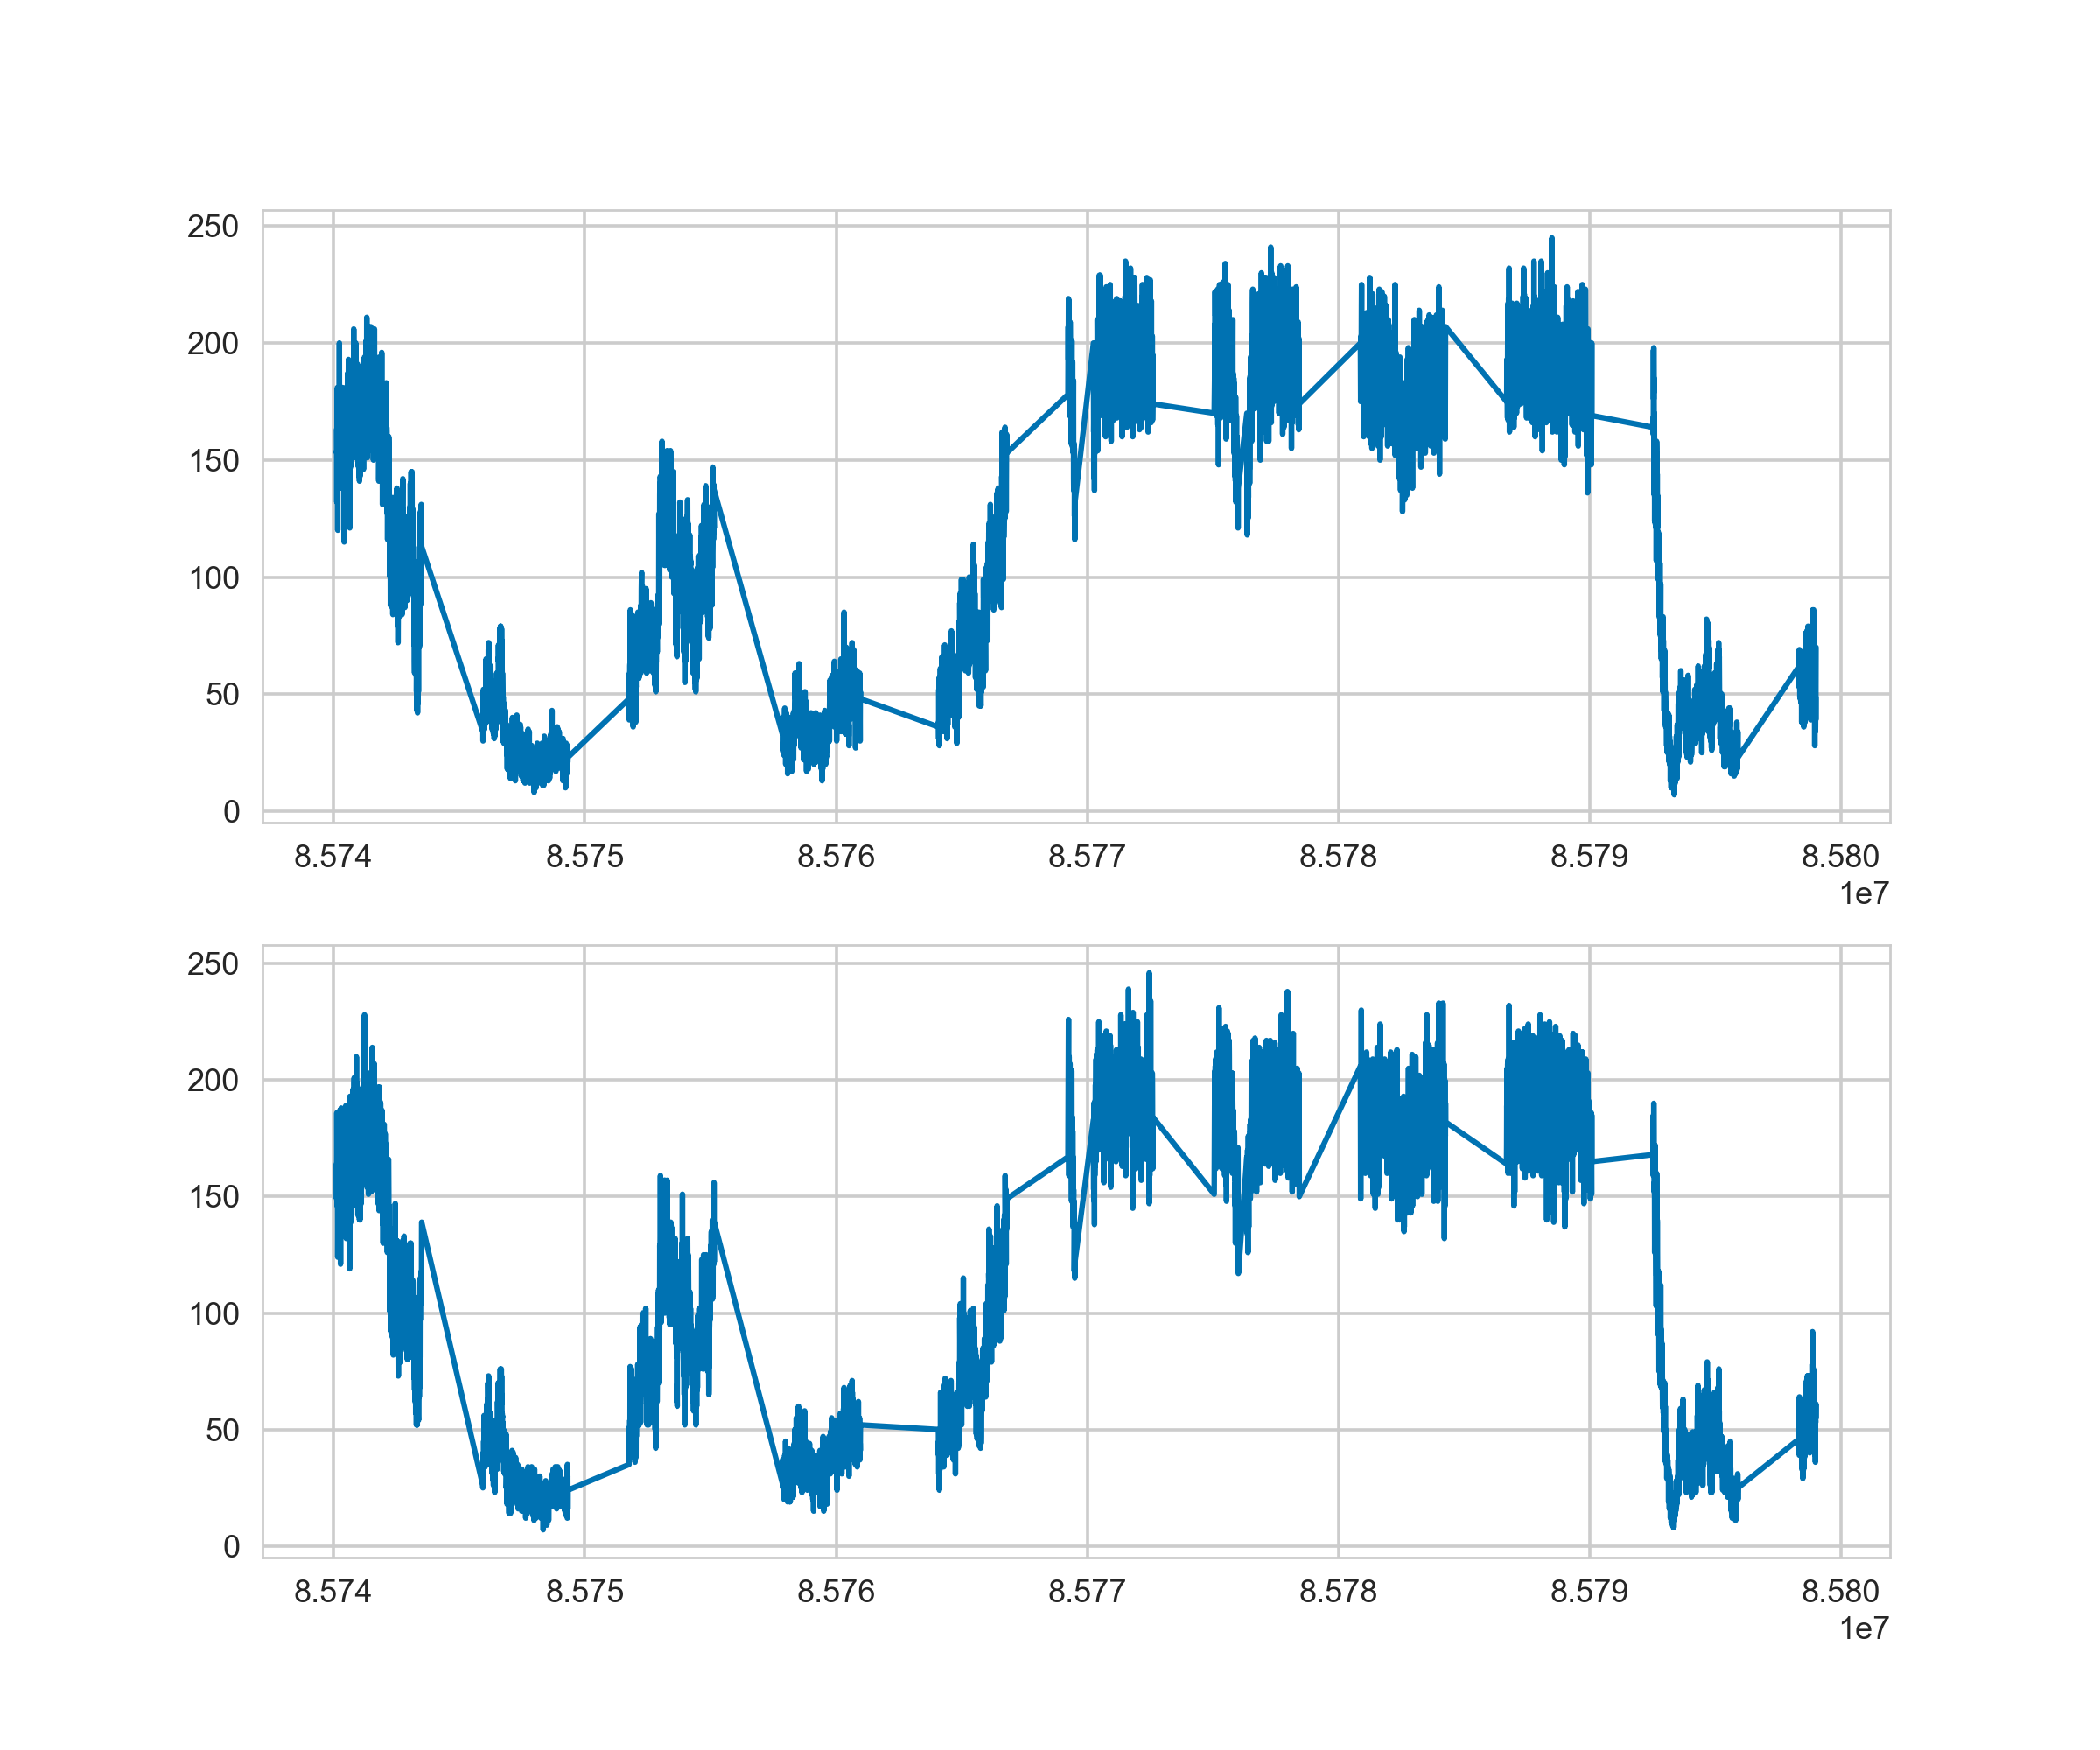

In [3]:
gti1 = np.array(list(zip(f1[2].data.field("START"), f1[2].data.field("STOP"))))
gti2 = np.array(list(zip(f2[2].data.field("START"), f2[2].data.field("STOP"))))

min_time = np.min(np.hstack([toa1, toa2]))
max_time = np.max(np.hstack([toa1, toa2]))

tseg = max_time - min_time

lc1 = Lightcurve.make_lightcurve(toa1, dt=5.0, tseg=tseg, tstart=min_time, gti=gti1)
lc2 = Lightcurve.make_lightcurve(toa2, dt=5.0, tseg=tseg, tstart=min_time, gti=gti2)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
ax1.plot(lc1.time, lc1.counts)
ax2.plot(lc2.time, lc2.counts)

I want to look at the distribution of GTIs to see if there are any long segments in the data:

<IPython.core.display.Javascript object>


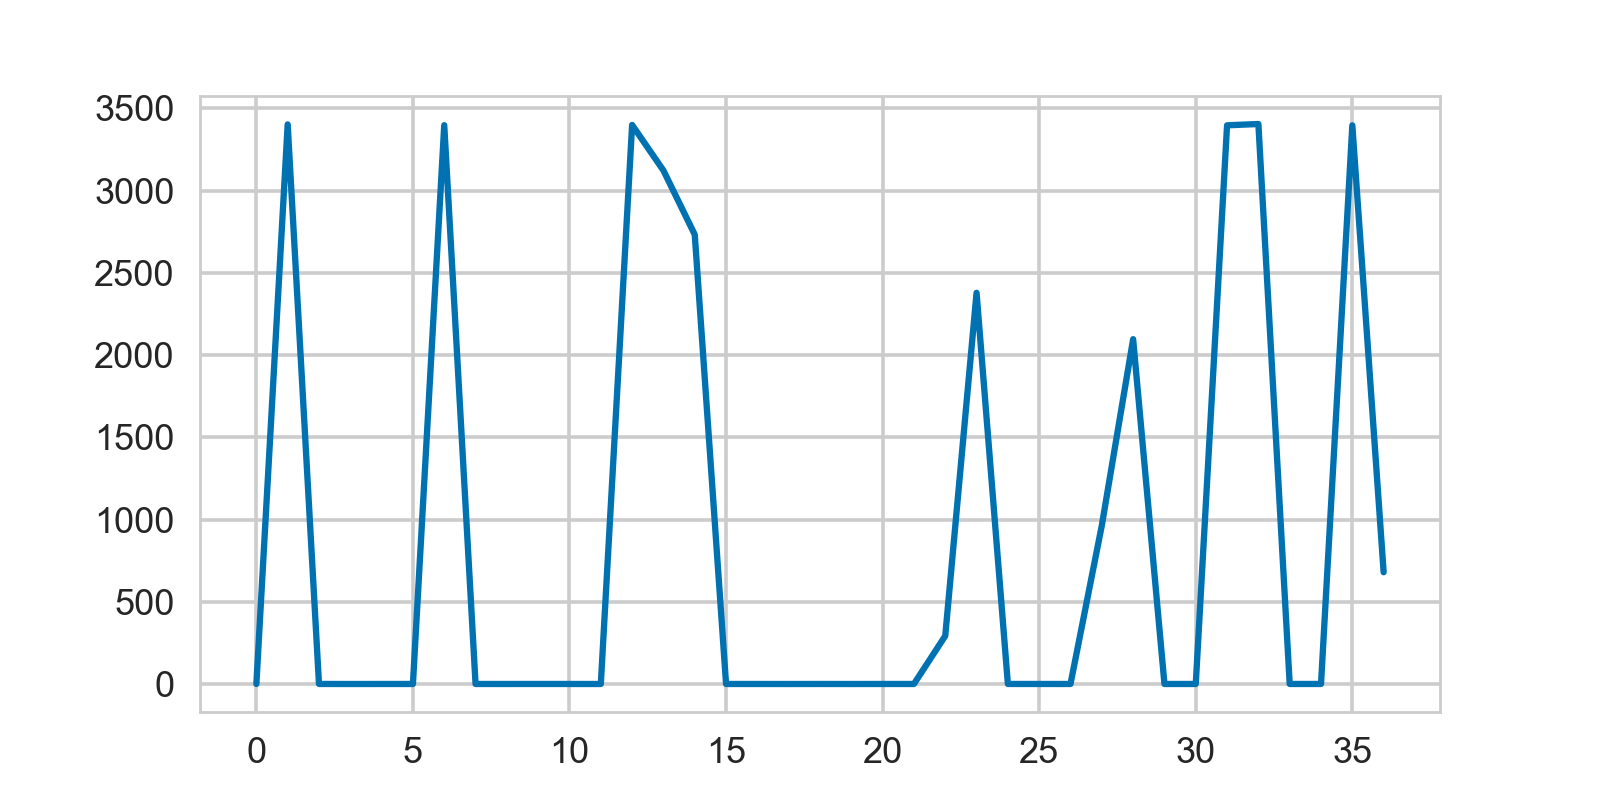

In [117]:
gti_length = gti1[:,1] - gti1[:,0]
plt.figure(figsize=(8,4))
plt.plot(gti_length)


Okay, that looks like there are some long intervals in there. 

We should cross the GTIs for both data sets into a single set of GTIs, otherwise our light curves might have different durations:

In [127]:
gtis = cross_gtis([gti1, gti2])

In [128]:
gti_length = gtis[:,1] - gtis[:,0]

In [129]:
np.sum(gti_length)

32673.343347430229

Let's pick only GTIs of a certain length, because there's a bunch of them that's really short!

In [130]:
len(gtis)

37

In [131]:
len(gti_length[gti_length >= 10.0])

13

In [132]:
gtis = gtis[gti_length >= 10.0]

In [133]:
len(gtis)

13

In [134]:
gti_length = gti_length[gti_length >= 10.0]

In [135]:
np.sum(gti_length)

32669.793330579996

In [136]:
32669.793330579996/32673.343347430229

0.9998913482219287

Now we're ready to make light curves:

In [24]:
dt = 0.5/700.0

In [14]:
lc1 = Lightcurve.make_lightcurve(toa1, dt=dt, tseg=(max_time-min_time), 
                                 tstart=min_time, gti=np.atleast_2d(gtis))

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:73: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [15]:
lc2 = Lightcurve.make_lightcurve(toa2, dt=dt, tseg=(max_time-min_time), 
                                 tstart=min_time, gti=np.atleast_2d(gtis))

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:73: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Let's combine the two light curves:

In [16]:
lc_comb = lc1 + lc2

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:73: UserWarning: SIMON says: Bin sizes in input time array aren't equal throughout! This could cause problems with Fourier transforms. Please make the input time evenly sampled.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


And we're going to make an averaged power spectrum with a segment size of 10 seconds, which should get us an incredibly well-constrained distribution and show dead time effects (if there are any):

In [17]:
seg_size = 10.0

In [18]:
avg_ps = AveragedPowerspectrum(lc_comb, segment_size=seg_size, norm="leahy")

In [19]:
avg_cs = AveragedCrossspectrum(lc1, lc2, segment_size=seg_size, norm="leahy")

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


How many averaged segments are in my PSD?

In [20]:
avg_ps.m

3260

Let's make a set of light curves for prettier plotting without connections between segments:

In [21]:
lc_plot = []

plot_dt = 1.0

for g in gtis:
    try:
        lc1_tmp = Lightcurve.make_lightcurve(toa1, dt=plot_dt, tseg=(g[1]-g[0]), tstart=g[0], gti=gtis)
        lc2_tmp = Lightcurve.make_lightcurve(toa2, dt=plot_dt, tseg=(g[1]-g[0]), tstart=g[0], gti=gtis)
    except StingrayError:
        continue
    lc_comb_tmp = lc1_tmp + lc2_tmp
    
    lc_plot.append(lc_comb_tmp)

And now we can plot both the light curve and the PSD:

<IPython.core.display.Javascript object>


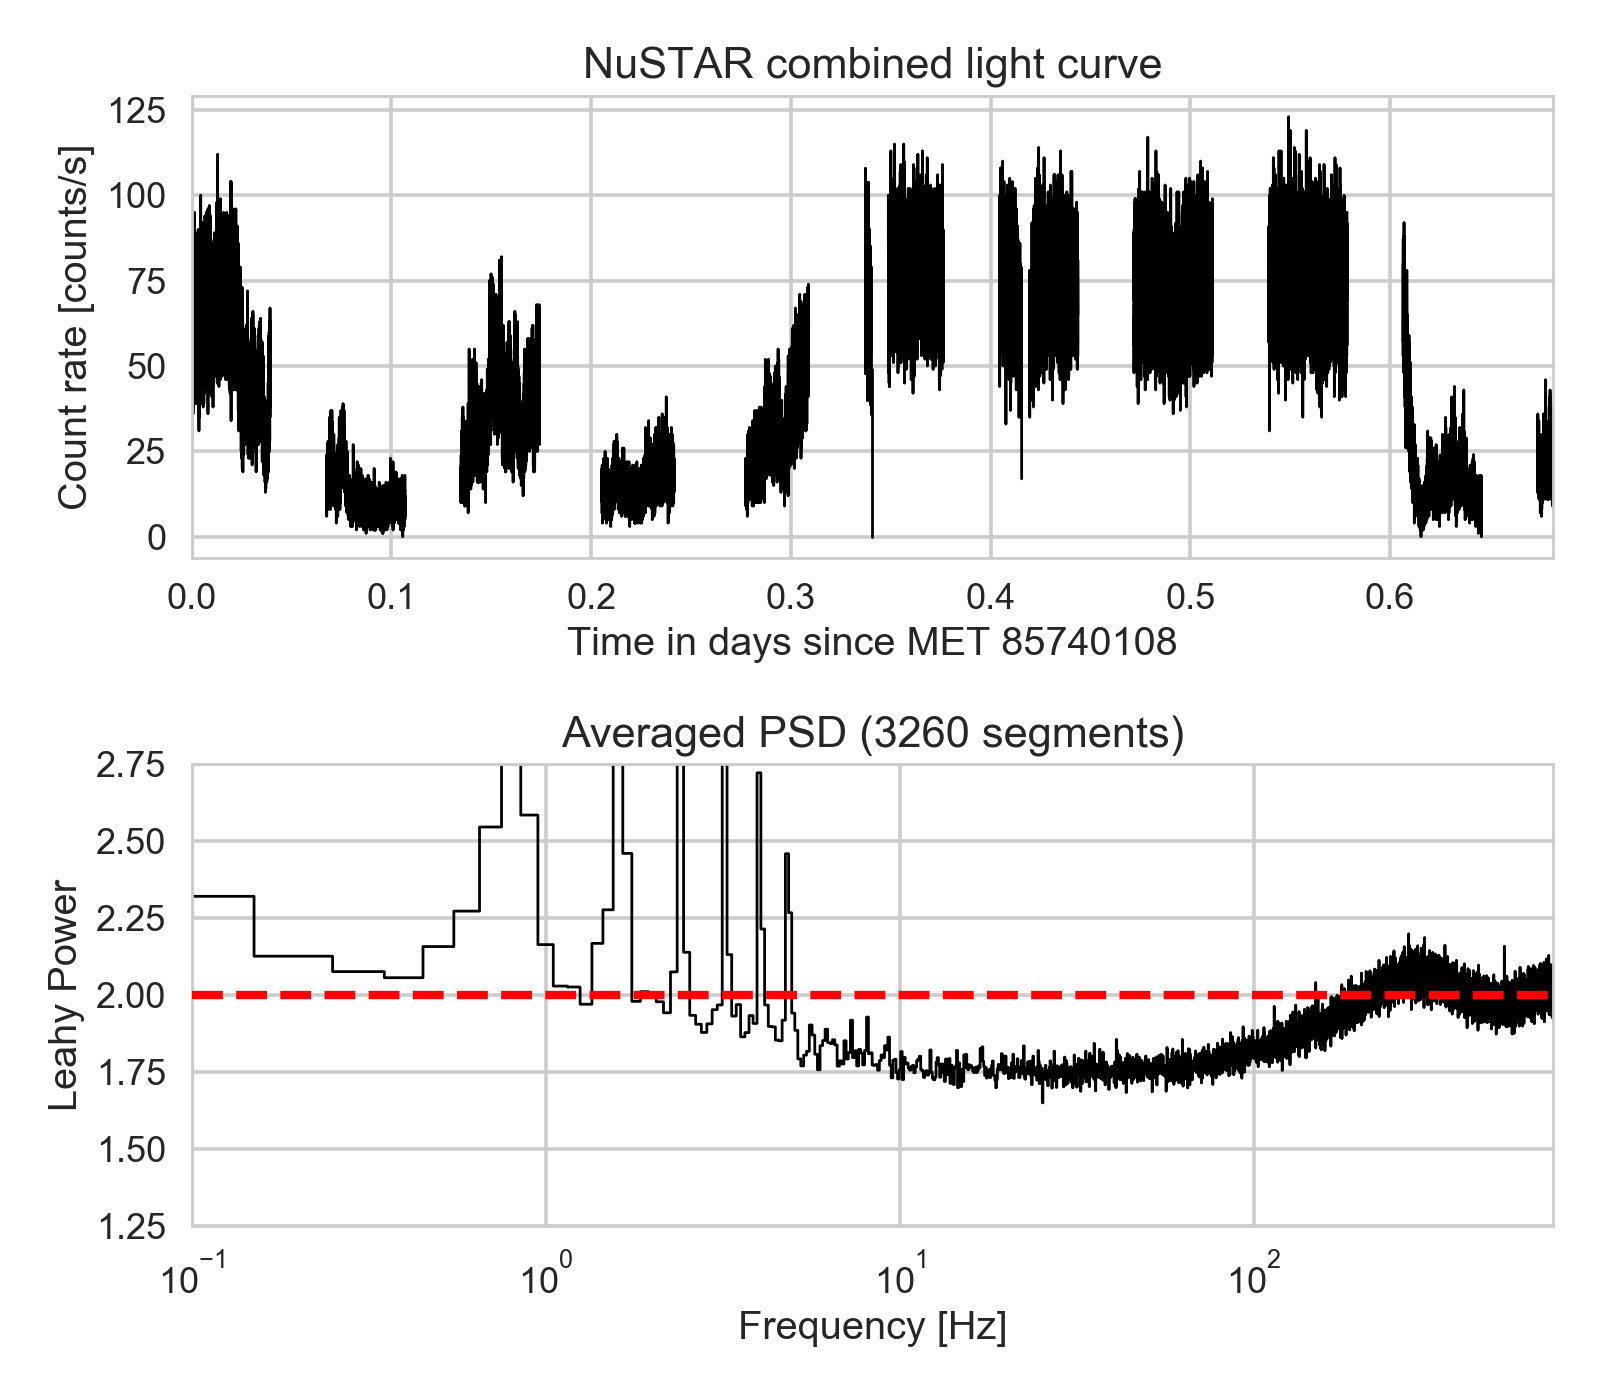

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,7))

for l in lc_plot:
    ax1.plot((l.time - min_time)/(60*60*24), l.countrate, lw=1, color="black", linestyle="steps-mid")
ax1.set_xlim(0, (max_time-min_time)/(60*60*24))
ax1.set_xlabel("Time in days since MET %.0f"%min_time)
ax1.set_ylabel("Count rate [counts/s]")
ax1.set_title("NuSTAR combined light curve")

ax2.semilogx(avg_ps.freq, avg_ps.power, linestyle="steps-mid", color="black", lw=1)
ax2.hlines(2.0, avg_ps.freq[0], avg_ps.freq[-1], lw=3, color="red", linestyle="dashed", zorder=10)
ax2.set_ylim(1.25,2.75)
ax2.set_xlim(avg_ps.freq[0], 700.0)
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy Power")
ax2.set_title("Averaged PSD (%i segments)"%avg_ps.m)

plt.tight_layout()

plt.savefig("../paper/nustar_lc_psd.pdf", format="pdf")
#ax2.semilogx(avg_cs.freq, avg_cs.power, linestyle="steps-mid", color="black", lw=1)
#ax2.set_ylim(-0.5, 0.5)

Okay, I also want to calculate the distributions of interest. Because of dead time, the distribution of Fourier amplitudes will *not* follow the expected Gaussian distribution, because the distribution should be a mixture of Gaussians even at high frequencies:

In [25]:
lc1_all = []
lc2_all = []

tseg = 10.0

for i,g in enumerate(gtis):
    gti_start = g[0]
    gti_end = g[1]
    
    tstart = gti_start
    tend = tstart + tseg
    
    while tend <= gti_end:
        s_ind1 = toa1.searchsorted(tstart)
        s_ind2 = toa2.searchsorted(tstart)
        
        e_ind1 = toa1.searchsorted(tend)
        e_ind2 = toa2.searchsorted(tend)
        
        toa1_tmp = toa1[s_ind1:e_ind1]
        toa2_tmp = toa2[s_ind2:e_ind2]
                
        lc1_tmp = Lightcurve.make_lightcurve(toa1_tmp, dt=dt, tstart=tstart, tseg=tseg)
        lc2_tmp = Lightcurve.make_lightcurve(toa2_tmp, dt=dt, tstart=tstart, tseg=tseg)
        
        lc1_all.append(lc1_tmp)
        lc2_all.append(lc2_tmp)

        tstart += tseg
        tend += tseg

In [26]:
var1_all, var2_all = [], []

f1_all = []
f2_all = []

ps1_all = []
ps2_all = []

cs_all = []

for lc1_tmp, lc2_tmp in zip(lc1_all, lc2_all):
            
        var1 = np.sum(lc1_tmp.counts)/2.0
        var2 = np.sum(lc2_tmp.counts)/2.0

        var1_all.append(var1)
        var2_all.append(var2)
                
        cs = Crossspectrum(lc1_tmp, lc2_tmp, norm="leahy")
        cs_all.append(cs)
    

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In [38]:
cs_powers_all = []

fmin = cs_all[0].freq.searchsorted(50.0)
fmax = cs_all[0].freq.searchsorted(700.0)

for cs in cs_all:
    cs_powers_all.extend(cs.power[fmin:fmax])


In [39]:
len(lc1_all)

3259

In [40]:
cs_powers_all = np.array(cs_powers_all)
print(len(cs_powers_all))

21183500


In [41]:
lapl = scipy.stats.laplace(0, 1.0)

u = np.linspace(-7.5, 7.5, 1000)
lapl_prob = lapl.pdf(u)

<IPython.core.display.Javascript object>


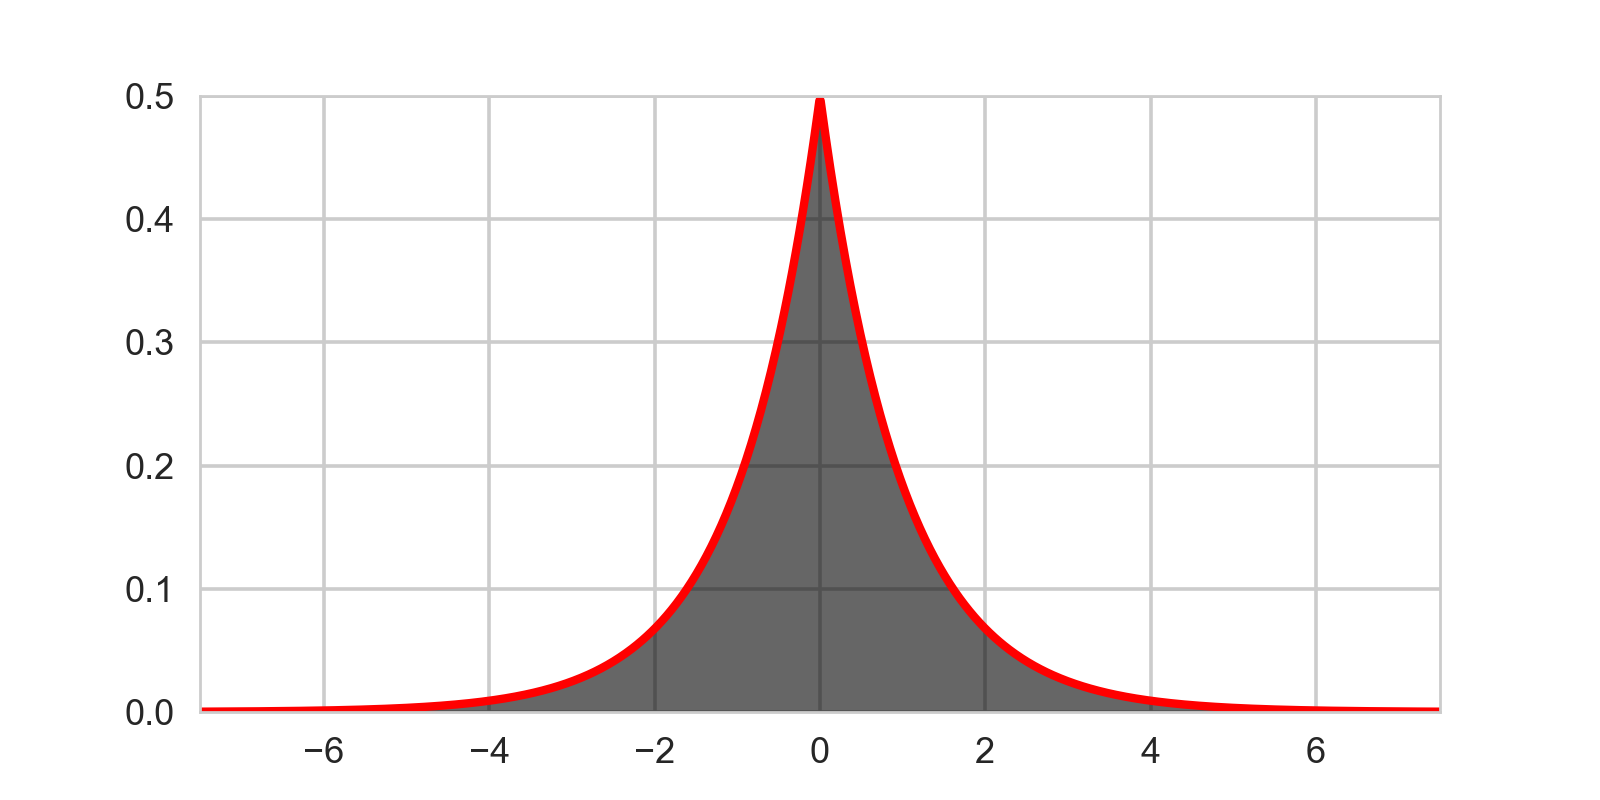

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.hist(cs_powers_all, range=[-7.5, 7.5], bins=1000, alpha=0.6, 
        color="black", normed=True, label="NuSTAR data")
ax.plot(u, lapl_prob, lw=3, color="red", label="theoretical prediction")
ax.set_xlim(-7.5, 7.5)
ax.set_ylim(0, 0.5)
ax

In [140]:
lapl_loc, lapl_scale = scipy.stats.laplace.fit(cs_powers_all)

In [141]:
lapl = scipy.stats.laplace(lapl_loc, lapl_scale)

u = np.linspace(-7.5, 7.5, 1000)
lapl_pdf = lapl.pdf(u)

In [142]:
scipy.stats.kstest(cs_powers_all, lapl.cdf)

KstestResult(statistic=0.00017687350610159913, pvalue=0.52142981077554007)

Awesome, that looks exactly like I expect. Let's also make an averaged cross spectrum and look at the distribution for those. 

In order to get enough statistics for our distribution, we're going to look at GTIs longer than 3000 seconds, extract a light curve of 3000 second duration from each, and make averaged power spectra with 15 averaged segments of 200 seconds each:

In [50]:
gti_length = gti_length[gti_length > 10.0]

In [51]:
gtis_long = gtis[gti_length >= 3000.0]

In [55]:
avg_cs_all = []

tseg = 200.0
gti_len = 3000.0
dt = 0.5/700.0

for i,g in enumerate(gtis_long):
    gti_start = g[0]
    gti_end = g[0] + gti_len
        
    s_ind1 = toa1.searchsorted(gti_start)
    s_ind2 = toa2.searchsorted(gti_start)

    e_ind1 = toa1.searchsorted(gti_end)
    e_ind2 = toa2.searchsorted(gti_end)
        
    toa1_tmp = toa1[s_ind1:e_ind1]
    toa2_tmp = toa2[s_ind2:e_ind2]
    
    lc1_tmp = Lightcurve.make_lightcurve(toa1_tmp, dt=dt, tstart=gti_start, 
                                         tseg=gti_len, gti=[[gti_start, gti_end]])
    lc2_tmp = Lightcurve.make_lightcurve(toa2_tmp, dt=dt, tstart=gti_start, 
                                         tseg=gti_len, gti=[[gti_start, gti_end]])
        
    avg_cs_tmp = AveragedCrossspectrum(lc1_tmp, lc2_tmp, segment_size=200.0, norm="leahy")
    print("Number of segments: " + str(avg_cs_tmp.m))
    
    avg_cs_all.append(avg_cs_tmp)


/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Number of segments: 15
Number of segments: 15
Number of segments: 15
Number of segments: 15
Number of segments: 15
Number of segments: 15
Number of segments: 15


This should give us 7 averaged cospectra with 15 segments each. 

We can now extract the powers between 50 and 700 Hz again and plot the distribution, along with the theoretically expected distribution:

In [106]:
fmin = avg_cs_all[0].freq.searchsorted(50.0)
fmax = avg_cs_all[0].freq.searchsorted(700.0)

avg_cs_powers_all = []

for cs in avg_cs_all:
    avg_cs_powers_all.extend(cs.power[fmin:fmax])
    
avg_cs_powers_all = np.array(avg_cs_powers_all)
print(len(avg_cs_powers_all))

910000


Awesome. We need the PDF for averaged cospectra, which exists in the AveragedCospectra.ipynb notebook:

In [107]:
def averaged_cospectra_pdf(x, n):
    absnx = np.abs(n*x)
    prefac_bottom1 = scipy.misc.factorial(n-1)
    prefac_bottom2 = 2.0**n
    
    numerical_prefac = n/(prefac_bottom1*prefac_bottom2)
    prefac = numerical_prefac * np.exp(-absnx)
    
    sum_all = np.zeros_like(x)
    for j in range(n):
        inside1 = n-1+j
        sum_factorial_top = scipy.misc.factorial(inside1)
        
        inside2 = n - 1 - j
        sum_factorial_bottom = scipy.misc.factorial(inside2)
        
        sum_factorial_bottom2 = scipy.misc.factorial(j)
        
        sum_bin_factor = 2.0**j
        
        exponent = n - 1 - j
        
        exp_factor = absnx**exponent
        
        sum_all += (sum_factorial_top/(sum_factorial_bottom*sum_factorial_bottom2) * (exp_factor/sum_bin_factor))
        
    return sum_all*prefac

In [108]:
for cs in avg_cs_all:
    print(cs.m)

15
15
15
15
15
15
15


In [109]:
len(avg_cs_powers_all)

910000

In [110]:
min_cs = np.min(avg_cs_powers_all)
max_cs = np.max(avg_cs_powers_all)

avg_u = np.linspace(-2, 2, 5000)
avg_lapl_pdf = averaged_cospectra_pdf(avg_u, avg_cs_all[0].m)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  if sys.path[0] == '':
/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  from ipykernel import kernelapp as app
/opt/local/Library/Frameworks/Python.framework/Ver

<IPython.core.display.Javascript object>


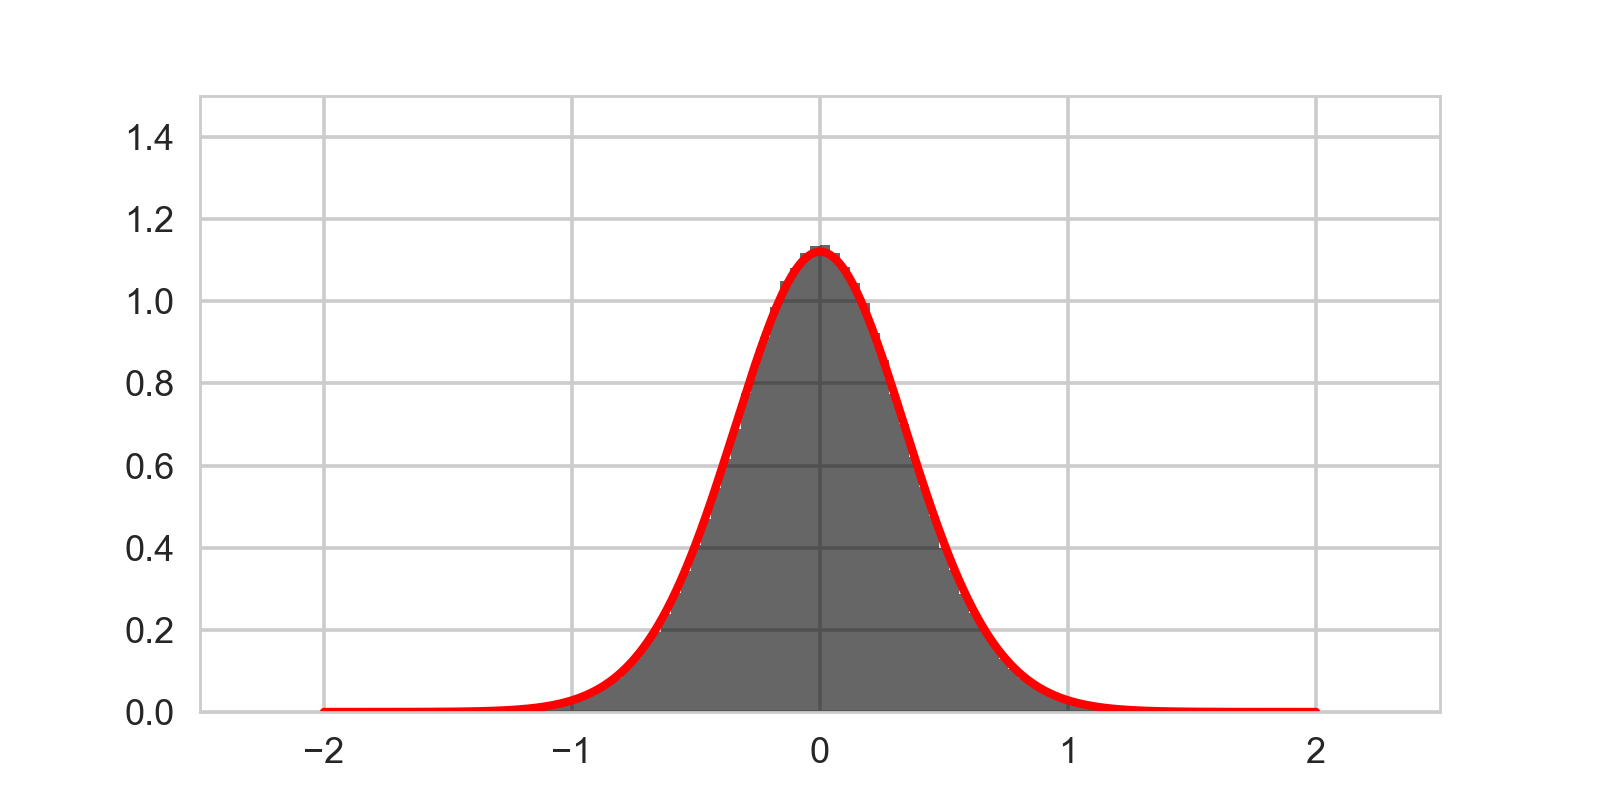

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.hist(avg_cs_powers_all, range=[-2.0, 2.0], bins=100, alpha=0.6, 
        color="black", normed=True, label="NuSTAR data")
ax.plot(avg_u, avg_lapl_pdf, lw=3, color="red", label="theoretical prediction")
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(0, 1.5)
ax

In [147]:
def averaged_cospectra_cdf(xcoord, n):
    cdf = np.zeros_like(xcoord)

    for i,x in enumerate(xcoord):
        prefac_bottom1 = scipy.misc.factorial(n-1)
        
        for j in range(n):
            prefac_top = n * scipy.misc.factorial(n-1+j)
            prefac_bottom2 = scipy.misc_factorial(n-1-j) * scipy.misc.factorial(j)
            prefac_bottom3 = 2.0**(n+j)
            
            prefac = prefac_top / (prefac_bottom1 * prefac_bottom2 * prefac_bottom3)
            
            if x >= 0:
                first_fac = 2.0*scipy.special.gamma(-j + n)
                second_fac = scipy.special.gammaincc(-j+n, n*x) * first_fac
                fac = first_fac + second_fac
            else:
                fac = scipy.special.gammaincc(-j+n, n*x) * first_fac
                
            cdf[i] += (prefac * fac)
                
    return cdf
        

Okay, let's plot these distributions together with the averaged cospectrum.

For illustration purposes, we'll make an averaged cospectrum of a short segment of 10 seconds from the first GTI:

In [83]:
gplot = gtis_long[0]

In [84]:
gplot

array([ 85740109.5408332,  85743512.6152242])

In [89]:
min_ind = lc1.time.searchsorted(gplot[0])
max_ind = lc1.time.searchsorted(gplot[0]+10.0)

In [92]:
lc1_t = lc1.truncate(start=min_ind, stop=max_ind)

In [93]:
lc2_t = lc2.truncate(start=min_ind, stop=max_ind)

In [146]:
lc1_t.time[0]

85740109.541690156

In [94]:
cs_plot = Crossspectrum(lc1_t, lc2_t, norm="leahy", gti=np.array([[gplot[0], gplot[0]+10.0]]))

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:73: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


In order to plot the detection limit, we need the inverse survival function of the Laplace distribution:

In [99]:
nfreq = len(cs_plot.freq)

In [101]:
detec_limit = lapl.isf(0.001/nfreq)

Let's plot all three together:

In [96]:
cs_plot.m

1

In [145]:
len(avg_cs_powers_all)

910000

<IPython.core.display.Javascript object>


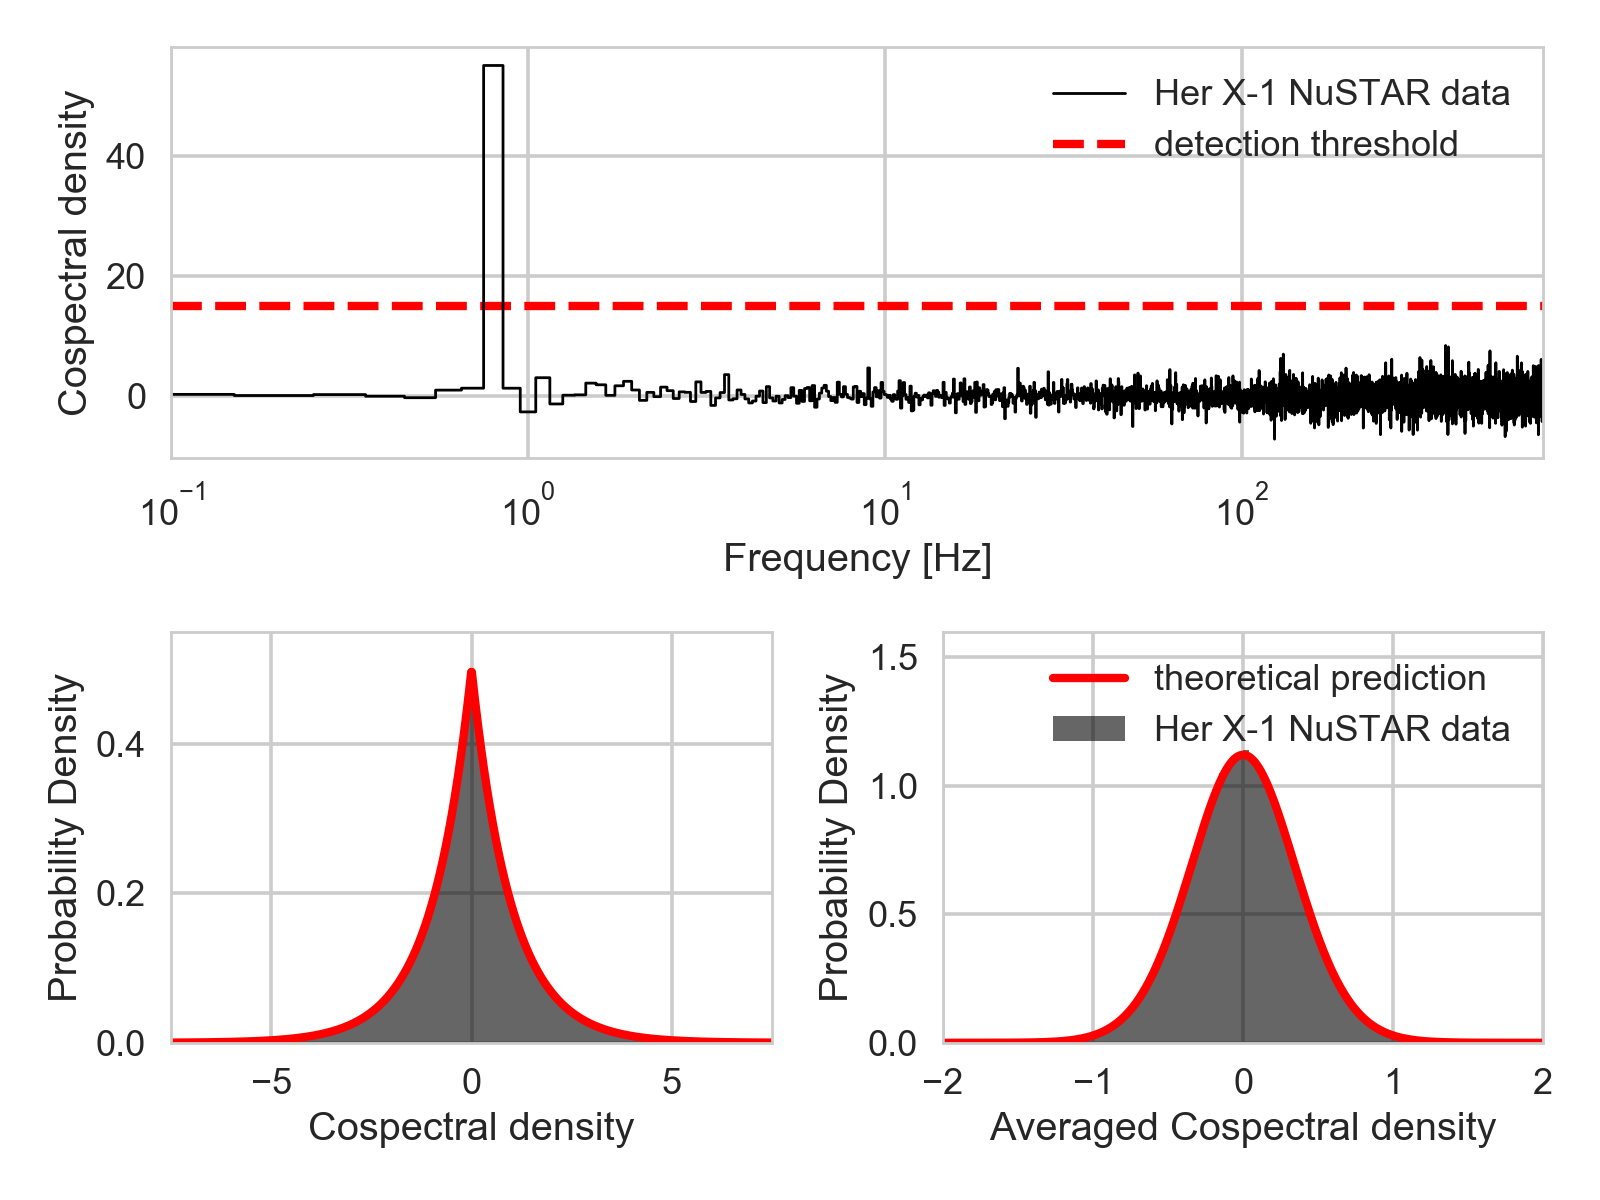

In [175]:

fig = plt.figure(figsize=(8,6))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax3 = plt.subplot2grid((2, 2), (1, 1))

ax1.semilogx(cs_plot.freq, cs_plot.power, lw=1, color="black", 
             linestyle="steps-mid", label="Her X-1 NuSTAR data")
ax1.hlines(detec_limit, cs_plot.freq[0], cs_plot.freq[-1], lw=3, 
           color="red", linestyle="dashed", label="detection threshold")

ax1.set_xlim(cs_plot.freq[0], cs_plot.freq[-1])
ax1.legend()
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Cospectral density")

ax2.hist(cs_powers_all, range=[-7.5, 7.5], bins=1000, alpha=0.6, 
        color="black", normed=True, label="Her X-1 NuSTAR data")
ax2.plot(u, lapl_prob, lw=3, color="red", label="theoretical prediction")
ax2.set_xlim(-7.5, 7.5)
ax2.set_ylim(0, 0.55)
ax2.set_xlabel("Cospectral density")
ax2.set_ylabel("Probability Density")

ax3.hist(avg_cs_powers_all, range=[-2.0, 2.0], bins=100, alpha=0.6, 
        color="black", normed=True, label="Her X-1 NuSTAR data")
ax3.plot(avg_u, avg_lapl_pdf, lw=3, color="red", label="theoretical prediction")
ax3.set_xlim(-2.0, 2.0)
ax3.set_ylim(0, 1.6)
ax3.set_xlabel("Averaged Cospectral density")
ax3.set_ylabel("Probability Density")

ax3.legend()

plt.tight_layout()

plt.savefig("../paper/nustar_cospectra.pdf", format='pdf')

Let's compute the p-value for the highest power:

In [151]:
max_pow = np.max(cs_plot.power)

In [174]:
max_pow

55.162922038494294

In [173]:
(1.0 - np.exp(lapl.logcdf(max_pow)))

0.0